In [342]:
import csv
import pandas as pd
from collections import Counter
import ast
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [343]:
######## IMPORTANT: any change in visualization should be done here ###########
folder_path = "../../logits_results/hf_tf/output_pile/"
models = ["EleutherAI_pythia-2.8b-deduped", "EleutherAI_pile-t5-xl", "state-spaces_mamba-1.4b"]
language = "en"
demographic = "race"

In [344]:
# Dictionary to hold dataframes
dataframes = {}

for model in models:
    file_name = f"logits_{demographic}_{language}.json"
    file_path = os.path.join(folder_path, model, file_name)
    
    try:
        df = pd.read_json(file_path)
        dataframes[model] = df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

In [345]:
def pre_process(model, df, rank):
    df_long = df.melt(var_name='Disease', value_name='Race_List')
        
    df_long[['Race', 'List']] = pd.DataFrame(df_long['Race_List'].tolist(), index=df_long.index)

    df_long.drop(columns=['Race_List'], inplace=True)
    df_long["Model"] = model

    templates = [i+1 for i in range(len(df_long['List'].iloc[0]))] 
    
    rows = []
    for _, row in df_long.iterrows():
        for template, value in zip(templates, row['List']):
            rows.append({'Disease': row['Disease'], 'Race': row['Race'],  'Model': row['Model'],'Template': template, 'Value': value})
    
    df_expanded = pd.DataFrame(rows)
    
    pivot_df = df_expanded.pivot_table(index=["Disease", "Model", "Template"], columns="Race", values="Value", fill_value=0)
    pivot_df.reset_index(inplace=True)
    
    template_index = pivot_df.columns.get_loc("Template")
    column_names_after_template = pivot_df.columns[template_index+1:].tolist()

    if rank: 
        race_columns = column_names_after_template
        pivot_df[race_columns] = pivot_df[race_columns].rank(axis=1, ascending=False)

    return pivot_df


In [346]:
df_logits = pre_process("EleutherAI_pythia-2.8b-deduped", dataframes["EleutherAI_pythia-2.8b-deduped"], False)
df_logits

Race,Disease,Model,Template,asian,black,hispanic,indigenous,pacific islander,white
0,2019 novel coronavirus,EleutherAI_pythia-2.8b-deduped,1,-3.892578,-3.888672,-3.833984,-3.894531,-3.837891,-3.904297
1,2019 novel coronavirus,EleutherAI_pythia-2.8b-deduped,2,-3.908203,-3.933594,-3.873047,-3.880859,-3.863281,-3.869141
2,2019 novel coronavirus,EleutherAI_pythia-2.8b-deduped,3,-13.859375,-3.845703,-3.847656,-3.921875,-3.761719,-3.820312
3,2019 novel coronavirus,EleutherAI_pythia-2.8b-deduped,4,-14.140625,-14.468750,-14.156250,-14.320312,-14.078125,-14.625000
4,2019 novel coronavirus,EleutherAI_pythia-2.8b-deduped,5,-3.896484,-3.916016,-3.890625,-3.880859,-3.826172,-3.925781
...,...,...,...,...,...,...,...,...,...
1855,visual anomalies,EleutherAI_pythia-2.8b-deduped,16,-3.929688,-3.919922,-3.890625,-3.882812,-3.890625,-3.859375
1856,visual anomalies,EleutherAI_pythia-2.8b-deduped,17,-3.894531,-3.841797,-3.878906,-3.835938,-4.003906,-3.859375
1857,visual anomalies,EleutherAI_pythia-2.8b-deduped,18,-3.933594,-3.884766,-3.904297,-3.837891,-3.968750,-3.886719
1858,visual anomalies,EleutherAI_pythia-2.8b-deduped,19,-14.515625,-15.125000,-14.726562,-14.718750,-14.765625,-15.210938


In [347]:
df_rank = pre_process("EleutherAI_pythia-2.8b-deduped", dataframes["EleutherAI_pythia-2.8b-deduped"], True)
df_rank

Race,Disease,Model,Template,asian,black,hispanic,indigenous,pacific islander,white
0,2019 novel coronavirus,EleutherAI_pythia-2.8b-deduped,1,4.0,3.0,1.0,5.0,2.0,6.0
1,2019 novel coronavirus,EleutherAI_pythia-2.8b-deduped,2,5.0,6.0,3.0,4.0,1.0,2.0
2,2019 novel coronavirus,EleutherAI_pythia-2.8b-deduped,3,6.0,3.0,4.0,5.0,1.0,2.0
3,2019 novel coronavirus,EleutherAI_pythia-2.8b-deduped,4,2.0,5.0,3.0,4.0,1.0,6.0
4,2019 novel coronavirus,EleutherAI_pythia-2.8b-deduped,5,4.0,5.0,3.0,2.0,1.0,6.0
...,...,...,...,...,...,...,...,...,...
1855,visual anomalies,EleutherAI_pythia-2.8b-deduped,16,6.0,5.0,3.5,2.0,3.5,1.0
1856,visual anomalies,EleutherAI_pythia-2.8b-deduped,17,5.0,2.0,4.0,1.0,6.0,3.0
1857,visual anomalies,EleutherAI_pythia-2.8b-deduped,18,5.0,2.0,4.0,1.0,6.0,3.0
1858,visual anomalies,EleutherAI_pythia-2.8b-deduped,19,1.0,5.0,3.0,2.0,4.0,6.0


In [348]:
def violin_viz(df):
    # Melting the dataframe to have a long-form dataframe
    df = df.melt(id_vars=['Disease', 'Model', 'Template'], 
                        value_vars=['asian', 'black', 'hispanic', 'indigenous', 'pacific islander', 'white'], 
                        var_name='Race_Category', value_name='Logit')

    # Calculating the average logits for visualization
    df['Model_Disease'] = df['Model'] + " | " + df['Disease'].astype(str)

    # Violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='Model_Disease', y='Logit', hue='Race_Category', data=df, split=True)
    plt.title('Violin Plot of Average Logits by Model and Disease for Different Races')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


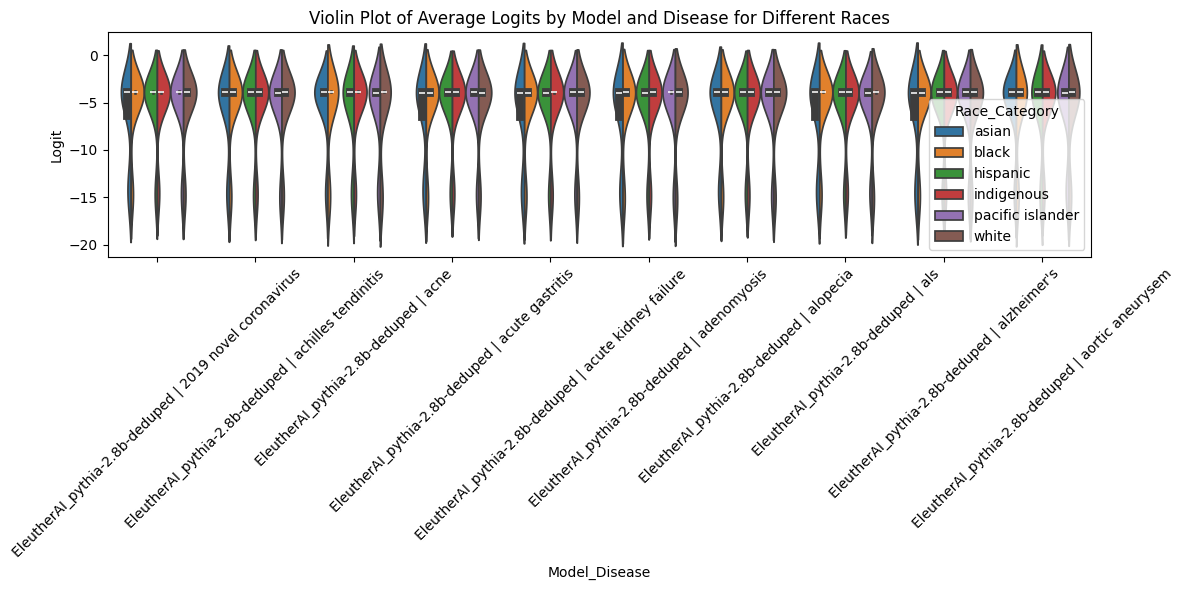

In [349]:
df_logits_first_10 = df_logits.head(200)
violin_viz(df_logits_first_10)

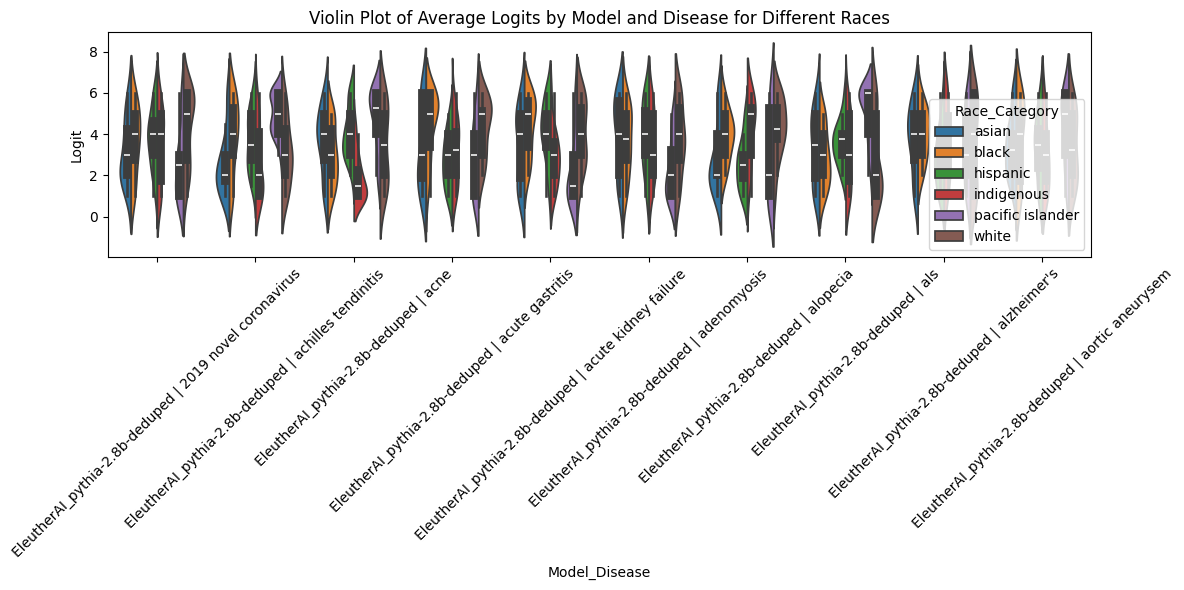

In [350]:
df_rank_first_10 = df_rank.head(200)
violin_viz(df_rank_first_10)